# Currency Note Damage Analysis Pipeline


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Written by Ovi, 2025-05-24
# Updated background removal and binary mask for improved damage detection

def remove_background(image):
    """Remove white background using saturation threshold"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    sat = hsv[:, :, 1]
    _, mask = cv2.threshold(sat, 20, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    result = image.copy()
    result[mask == 0] = [255, 255, 255]  # fill background with white

    return result, mask


def create_binary_mask(image):
    """Create robust binary mask for note area using adaptive threshold and contour filtering"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Adaptive thresholding handles uneven lighting
    binary = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=35,
        C=10
    )

    # Remove small noise
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Keep only largest contour (note shape)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(binary)
        cv2.drawContours(mask, [largest], -1, 255, cv2.FILLED)
        return mask
    else:
        return binary

def align_images(img1, img2):
    """Align img1 (torn) to img2 (standard)"""
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    
    if des1 is None or des2 is None:
        raise ValueError("Could not detect features for alignment")
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    if len(good_matches) < 4:
        raise ValueError("Not enough good matches found for alignment")
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    aligned_img = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
    return aligned_img


def apply_clahe_color_balance(image):
    """Apply CLAHE to each channel in LAB color space for contrast enhancement"""
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_eq = clahe.apply(l)
    lab_eq = cv2.merge((l_eq, a, b))
    result = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    return result

def calculate_rgb_damage(aligned_torn, reference):
    """Calculate RGB damage with CLAHE, smoothing, and noise suppression"""

    # Step 1: Contrast normalization using CLAHE
    aligned_torn = apply_clahe_color_balance(aligned_torn)
    reference = apply_clahe_color_balance(reference)

    # Step 2: Smooth to reduce color noise
    aligned_torn_smooth = cv2.bilateralFilter(aligned_torn, d=9, sigmaColor=75, sigmaSpace=75)
    reference_smooth = cv2.bilateralFilter(reference, d=9, sigmaColor=75, sigmaSpace=75)

    # Step 3: Create note region masks
    ref_mask = create_binary_mask(reference_smooth)
    torn_mask = create_binary_mask(aligned_torn_smooth)
    common_mask = cv2.bitwise_and(ref_mask, torn_mask)

    # Step 4: Compute RGB difference
    rgb_diff = cv2.absdiff(aligned_torn_smooth, reference_smooth)
    rgb_diff_gray = cv2.cvtColor(rgb_diff, cv2.COLOR_BGR2GRAY)

    # Step 5: Filter out low-level noise
    _, filtered_diff = cv2.threshold(rgb_diff_gray, 15, 255, cv2.THRESH_TOZERO)

    # Step 6: Mask outside regions
    masked_diff = cv2.bitwise_and(filtered_diff, filtered_diff, mask=common_mask)

    # Step 7: Compute normalized score
    total_pixels = np.sum(common_mask > 0)
    if total_pixels > 0:
        avg_rgb_diff = np.sum(masked_diff) / (total_pixels * 255.0)
    else:
        avg_rgb_diff = 0.0

    return masked_diff, avg_rgb_diff

def detect_edge_corner_damage(aligned_torn, standard_img, overlap_threshold=0.1):
    """
    Detects edge and corner damage.
    
    Args:
        aligned_torn (np.array): Aligned torn note image.
        standard_img (np.array): Aligned standard note image (same size).
        overlap_threshold (float): % overlap threshold to consider damaged (0.1 = 10%).

    Returns:
        dict: Report of which edges and corners are damaged.
    """
    def create_binary_mask(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((5, 5), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        return binary

    standard_binary = create_binary_mask(standard_img)
    aligned_binary = create_binary_mask(aligned_torn)
    damage_mask = cv2.subtract(standard_binary, aligned_binary)

    h, w = damage_mask.shape

    edge_thickness = int(0.05 * min(h, w))  

    masks = {
        'Top Edge': np.zeros((h, w), dtype=np.uint8),
        'Bottom Edge': np.zeros((h, w), dtype=np.uint8),
        'Left Edge': np.zeros((h, w), dtype=np.uint8),
        'Right Edge': np.zeros((h, w), dtype=np.uint8),
        'Top Left Corner': np.zeros((h, w), dtype=np.uint8),
        'Top Right Corner': np.zeros((h, w), dtype=np.uint8),
        'Bottom Left Corner': np.zeros((h, w), dtype=np.uint8),
        'Bottom Right Corner': np.zeros((h, w), dtype=np.uint8),
    }

    masks['Top Edge'][:edge_thickness, :] = 255
    masks['Bottom Edge'][-edge_thickness:, :] = 255
    masks['Left Edge'][:, :edge_thickness] = 255
    masks['Right Edge'][:, -edge_thickness:] = 255

    corner_size_x = int(0.1 * w)
    corner_size_y = int(0.1 * h)

    masks['Top Left Corner'][:corner_size_y, :corner_size_x] = 255
    masks['Top Right Corner'][:corner_size_y, -corner_size_x:] = 255
    masks['Bottom Left Corner'][-corner_size_y:, :corner_size_x] = 255
    masks['Bottom Right Corner'][-corner_size_y:, -corner_size_x:] = 255

    report = {}
    for region, mask in masks.items():
        region_mask = cv2.bitwise_and(damage_mask, damage_mask, mask=mask)
        total_area = np.sum(mask > 0)
        damaged_area = np.sum(region_mask > 0)
        overlap_ratio = damaged_area / total_area if total_area > 0 else 0

        report[region] = {
            'overlap_percentage': overlap_ratio * 100,
            'is_damaged': overlap_ratio >= overlap_threshold
        }

    print("\nEdge & Corner Damage Report:")
    for region, data in report.items():
        status = "Damaged" if data['is_damaged'] else "OK"
        print(f"{region}: {status} ({data['overlap_percentage']:.1f}% damaged)")

    return report


import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color

def apply_gray_world_white_balance(img):
    """Basic gray-world white balance correction."""
    result = img.copy().astype(np.float32)
    avg_b = np.mean(result[:, :, 0])
    avg_g = np.mean(result[:, :, 1])
    avg_r = np.mean(result[:, :, 2])
    avg_gray = (avg_b + avg_g + avg_r) / 3

    result[:, :, 0] *= (avg_gray / avg_b)
    result[:, :, 1] *= (avg_gray / avg_g)
    result[:, :, 2] *= (avg_gray / avg_r)

    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

def create_binary_mask(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    return binary



In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def advanced_feature_detection_and_check(aligned_torn, standard_img, min_match_score=0.5):
    """
    Detect key features (denomination, portrait, seal, serials, signature) from standard note,
    match them against torn note, and mark presence.
    """
    print("\n Advanced feature detection & checking starting...")

    gray_standard = cv2.cvtColor(standard_img, cv2.COLOR_BGR2GRAY)
    gray_torn = cv2.cvtColor(aligned_torn, cv2.COLOR_BGR2GRAY)

    h, w = gray_standard.shape

    thresh = cv2.adaptiveThreshold(gray_standard, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 21, 10)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f"➡ Detected {len(contours)} raw contours.")

    contour_info = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 50:  
            continue
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        contour_info.append({'contour': cnt, 'area': area, 'centroid': (cX, cY)})

    print(f"➡ {len(contour_info)} contours kept after filtering.")

    if not contour_info:
        print("No valid contours found.")
        return {}

    coords = np.array([info['centroid'] for info in contour_info])
    clustering = DBSCAN(eps=20, min_samples=1).fit(coords)
    labels = clustering.labels_

    num_clusters = len(set(labels))
    print(f"Grouped into {num_clusters} feature clusters.")

    feature_results = {}
    vis_img = aligned_torn.copy()

    for cluster_id in range(num_clusters):
        cluster_contours = [info['contour'] for i, info in enumerate(contour_info) if labels[i] == cluster_id]
        if not cluster_contours:
            continue

        # Merge all contours in this cluster
        merged_mask = np.zeros_like(gray_standard)
        cv2.drawContours(merged_mask, cluster_contours, -1, 255, -1)

        # Get bounding box of merged region
        x, y, bw, bh = cv2.boundingRect(np.vstack(cluster_contours))

        if bw < 10 or bh < 10:
            continue  # skip trivial

        template = gray_standard[y:y+bh, x:x+bw]

        res = cv2.matchTemplate(gray_torn, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)

        status = "Present" if max_val >= min_match_score else "Missing/Partial"

        feature_name = f"Feature Cluster {cluster_id + 1}"
        feature_results[feature_name] = {
            'bbox_in_standard': (x, y, bw, bh),
            'match_score': max_val,
            'status': status
        }


        color = (0, 255, 0) if status == "Present" else (0, 0, 255)
        cv2.rectangle(vis_img, (x, y), (x + bw, y + bh), color, 2)
        

    plt.figure(figsize=(7, 6))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("advanced_feature_detection.png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

    return feature_results


In [21]:

def analyze_currency(torn_path, standard_path):
    """Main analysis function (no saving, reports top 5 damaged areas)"""
    # Read and process images
    torn_img = cv2.imread(torn_path)
    standard_img = cv2.imread(standard_path)
    
    if torn_img is None or standard_img is None:
        raise ValueError("Could not read images")
    
    size = (800, 400)
    torn_img = cv2.resize(torn_img, size)
    standard_img = cv2.resize(standard_img, size)
    
    print("Removing backgrounds...")
    torn_clean, _ = remove_background(torn_img)
    standard_clean, _ = remove_background(standard_img)
    
    print("Aligning images...")
    aligned_torn = align_images(torn_clean, standard_clean)
    
    print("Processing analysis...")
    standard_binary = create_binary_mask(standard_clean)
    aligned_binary = create_binary_mask(aligned_torn)
    binary_diff = cv2.subtract(standard_binary, aligned_binary)

    print("Detecting edge and corner damage...")
    edge_corner_report = detect_edge_corner_damage(aligned_torn, standard_clean)

    # print("Calculating color distortion...")
    # color_distortion_report = color_distortion_scoring(aligned_torn, standard_clean, show_heatmap=False)

    print("Checking key features presence...")
    feature_report = advanced_feature_detection_and_check(aligned_torn, standard_clean)
    
    total_pixels = np.sum(standard_binary > 0)
    missing_pixels = np.sum(binary_diff > 0)
    binary_damage_ratio = (missing_pixels / total_pixels) * 100 if total_pixels > 0 else 0
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_diff, connectivity=8)
    
    damage_areas = []
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area > 50:  
            cx, cy = centroids[i]
            damage_areas.append({
                'area': area,
                'centroid': (int(cx), int(cy))
            })
    
    damage_areas = sorted(damage_areas, key=lambda x: x['area'], reverse=True)
    
    height, width = aligned_torn.shape[:2]
    def get_zone(x, y, w, h):
        """Map centroid to a broad zone."""
        row = ''
        col = ''
        if y < h / 3:
            row = 'Top'
        elif y < (2 * h) / 3:
            row = 'Middle'
        else:
            row = 'Bottom'
        if x < w / 3:
            col = 'Left'
        elif x < (2 * w) / 3:
            col = 'Center'
        else:
            col = 'Right'
        return f"{row} {col}"
    
    print("\nTop 5 damaged areas (if available):")
    for idx, region in enumerate(damage_areas[:5], 1):
        cx, cy = region['centroid']
        zone = get_zone(cx, cy, width, height)
        print(f"Damage {idx}: Location - {zone}, Area: {region['area']} px")
    
    rgb_diff_mask, rgb_damage_ratio = calculate_rgb_damage(aligned_torn, standard_clean)
    rgb_damage_percentage = rgb_damage_ratio * 100
    
    damage_overlay = aligned_torn.copy()
    damage_overlay[binary_diff > 0] = [0, 0, 255]  
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(damage_overlay, cv2.COLOR_BGR2RGB))
    plt.title(f'Area Analysis (Torn ratio)\n{binary_damage_ratio:.1f}%')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(rgb_diff_mask, cmap='hot')
    plt.title(f'RGB Difference Analysis\n{rgb_damage_percentage:.1f}%')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\nDamage Analysis Results:")
    print(f"Binary Damage: {binary_damage_ratio:.1f}%")
    print(f"RGB Damage: {rgb_damage_percentage:.1f}%")

    return {
        'binary_damage': binary_damage_ratio,
        'rgb_damage': rgb_damage_percentage
    }

In [23]:
# Written by Ovi, 2025-05-24
# Full damage analysis including binary, RGB, edge/corner, feature loss, and CCDS scoring

def analyze_currency2(torn_path, standard_path):
    """Main analysis function (no saving, reports top 5 damaged areas)"""
    # Read and process images
    torn_img = cv2.imread(torn_path)
    standard_img = cv2.imread(standard_path)

    if torn_img is None or standard_img is None:
        raise ValueError("Could not read images")

    size = (800, 400)
    torn_img = cv2.resize(torn_img, size)
    standard_img = cv2.resize(standard_img, size)

    print("Removing backgrounds...")
    torn_clean, _ = remove_background(torn_img)
    standard_clean, _ = remove_background(standard_img)

    print("Aligning images...")
    aligned_torn = align_images(torn_clean, standard_clean)

    print("Processing analysis...")
    standard_binary = create_binary_mask(standard_clean)
    aligned_binary = create_binary_mask(aligned_torn)
    binary_diff = cv2.subtract(standard_binary, aligned_binary)

    print("Detecting edge and corner damage...")
    edge_corner_report = detect_edge_corner_damage(aligned_torn, standard_clean)

    print("Checking key features presence...")
    feature_report = advanced_feature_detection_and_check(aligned_torn, standard_clean)

    total_pixels = np.sum(standard_binary > 0)
    missing_pixels = np.sum(binary_diff > 0)
    binary_damage_ratio = (missing_pixels / total_pixels) * 100 if total_pixels > 0 else 0

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_diff, connectivity=8)

    damage_areas = []
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area > 50:
            cx, cy = centroids[i]
            damage_areas.append({
                'area': area,
                'centroid': (int(cx), int(cy))
            })

    damage_areas = sorted(damage_areas, key=lambda x: x['area'], reverse=True)

    height, width = aligned_torn.shape[:2]
    def get_zone(x, y, w, h):
        """Map centroid to a broad zone."""
        row = ''
        col = ''
        if y < h / 3:
            row = 'Top'
        elif y < (2 * h) / 3:
            row = 'Middle'
        else:
            row = 'Bottom'
        if x < w / 3:
            col = 'Left'
        elif x < (2 * w) / 3:
            col = 'Center'
        else:
            col = 'Right'
        return f"{row} {col}"

    print("\nTop 5 damaged areas (if available):")
    for idx, region in enumerate(damage_areas[:5], 1):
        cx, cy = region['centroid']
        zone = get_zone(cx, cy, width, height)
        print(f"Damage {idx}: Location - {zone}, Area: {region['area']} px")

    rgb_diff_mask, rgb_damage_ratio = calculate_rgb_damage(aligned_torn, standard_clean)
    rgb_damage_percentage = rgb_damage_ratio * 100

    damage_overlay = aligned_torn.copy()
    damage_overlay[binary_diff > 0] = [0, 0, 255]

    plt.figure(figsize=(7, 6))
    plt.imshow(cv2.cvtColor(damage_overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("area_damage_overlay.png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

    plt.figure(figsize=(7, 6))
    plt.imshow(rgb_diff_mask, cmap='hot')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("rgb_difference_mask.png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

    print("\nDamage Analysis Results:")
    print(f"Binary Damage: {binary_damage_ratio:.1f}%")
    print(f"RGB Damage: {rgb_damage_percentage:.1f}%")

    # --- CCDS Calculation ---
    epsilon = 1e-5
    Z_max = 20  # Based on dataset or empirical observation

    B = binary_damage_ratio
    R = rgb_damage_percentage

    num_damaged_edges = sum(1 for k in ['Top Edge', 'Bottom Edge', 'Left Edge', 'Right Edge']
                            if edge_corner_report[k]['is_damaged'])
    num_damaged_corners = sum(1 for k in ['Top Left Corner', 'Top Right Corner',
                                          'Bottom Left Corner', 'Bottom Right Corner']
                              if edge_corner_report[k]['is_damaged'])

    F = sum(1 for v in feature_report.values() if v['status'] != "Present")
    N = len(feature_report)

    Z = len(damage_areas)

    # Normalize and transform
    B_norm = B / (100 + epsilon)
    R_norm = R / (100 + epsilon)
    E_norm = num_damaged_edges / 4
    C_norm = num_damaged_corners / 4
    F_norm = F / (N + epsilon)
    Z_norm = Z / (Z_max + epsilon)

    # B_term = B_norm ** 1.2
    # R_term = R_norm ** 1.2
    # E_term = E_norm ** 1.5
    # C_term = C_norm ** 1.5
    # F_term = F_norm ** 2
    # Z_term = np.tanh(Z_norm)
    B_term = B_norm * 2.0
    R_term = R_norm * 2.0
    E_term = E_norm * 1.5
    C_term = C_norm ** 1.5
    F_term = np.log(1 + F_norm)
    Z_term = np.tanh(Z_norm)

    w1, w2, w3, w4, w5, w6 = 0.4, 0.2, 0.15, 0.15, 0.05, 0.05
    ccds = 1 - (w1 * B_term + w2 * R_term + w3 * E_term + w4 * C_term + w5 * F_term + w6 * Z_term)

    if F / N > 0.45 and B > 5:
        ccds = min(ccds, 0.65)

    damage_summary = {
        'Binary Damage (%)': B,
        'RGB Damage (%)': R,
        'Damaged Edges': num_damaged_edges,
        'Damaged Corners': num_damaged_corners,
        'Missing Features': F,
        'Total Features': N,
        'Damage Areas': Z,
        'CCDS Score': ccds
    }

    print("\nFinal CCDS Damage Summary:")
    for k, v in damage_summary.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    return {
        'binary_damage': B,
        'rgb_damage': R,
        'edge_corner_report': edge_corner_report,
        'feature_report': feature_report,
        'damage_areas': damage_areas,
        'ccds_score': ccds,
        'summary': damage_summary
    }

Removing backgrounds...
Aligning images...
Processing analysis...
Detecting edge and corner damage...

Edge & Corner Damage Report:
Top Edge: Damaged (16.1% damaged)
Bottom Edge: OK (0.3% damaged)
Left Edge: OK (1.4% damaged)
Right Edge: Damaged (56.1% damaged)
Top Left Corner: OK (3.5% damaged)
Top Right Corner: Damaged (100.0% damaged)
Bottom Left Corner: OK (0.0% damaged)
Bottom Right Corner: OK (0.0% damaged)
Checking key features presence...

 Advanced feature detection & checking starting...
➡ Detected 9671 raw contours.
➡ 67 contours kept after filtering.
Grouped into 60 feature clusters.


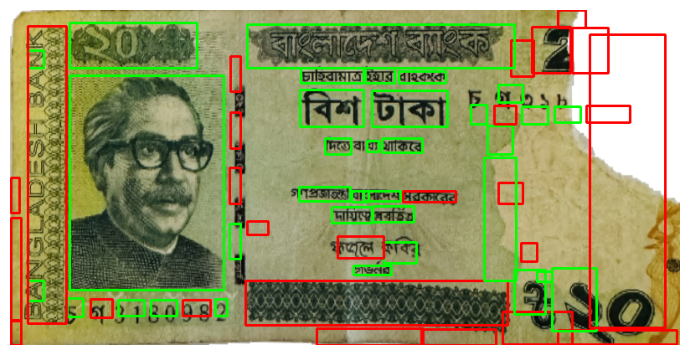


Top 5 damaged areas (if available):
Damage 1: Location - Top Right, Area: 24446 px
Damage 2: Location - Top Left, Area: 113 px
Damage 3: Location - Bottom Center, Area: 51 px


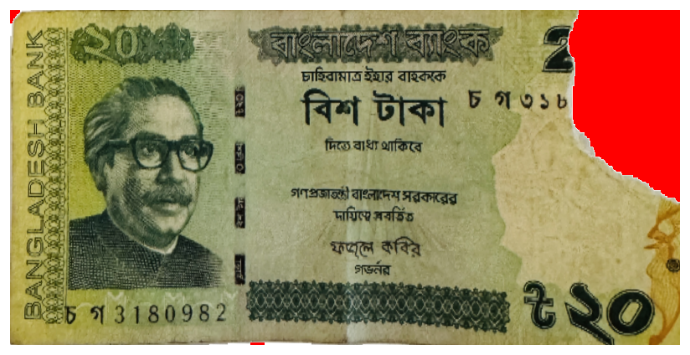

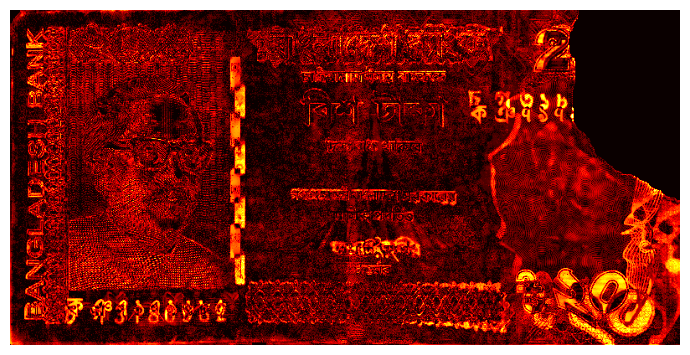


Damage Analysis Results:
Binary Damage: 7.7%
RGB Damage: 13.9%

Final CCDS Damage Summary:
Binary Damage (%): 7.6906
RGB Damage (%): 13.8539
Damaged Edges: 2
Damaged Corners: 1
Missing Features: 26
Total Features: 60
Damage Areas: 3
CCDS Score: 0.7264


In [24]:
if __name__ == "__main__":
    try:
        # analyze_currency('dataset/data_torn/20tornt_back.jpg', 'standard_notes/20_back_standard.jpg')
        analyze_currency2('data_torn/fig_20_torn_note.png', 'standard_notes/20_standard.jpg')
    except Exception as e:
        print(f"Error: {str(e)}")

Removing backgrounds...
Aligning images...
Processing analysis...
Detecting edge and corner damage...

Edge & Corner Damage Report:
Top Edge: OK (0.0% damaged)
Bottom Edge: OK (0.0% damaged)
Left Edge: OK (0.0% damaged)
Right Edge: OK (0.0% damaged)
Top Left Corner: OK (0.0% damaged)
Top Right Corner: OK (0.0% damaged)
Bottom Left Corner: OK (0.0% damaged)
Bottom Right Corner: OK (0.0% damaged)
Checking key features presence...

 Advanced feature detection & checking starting...
➡ Detected 9513 raw contours.
➡ 110 contours kept after filtering.
Grouped into 101 feature clusters.


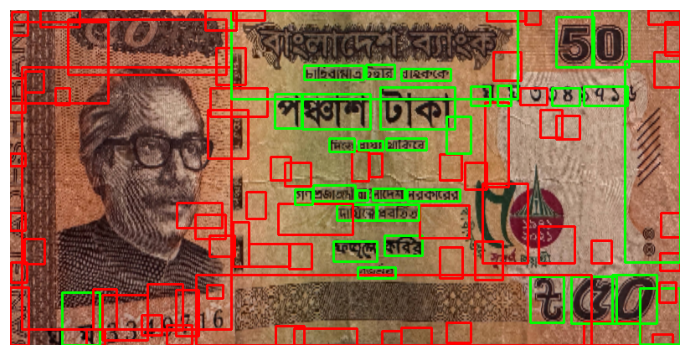


Top 5 damaged areas (if available):


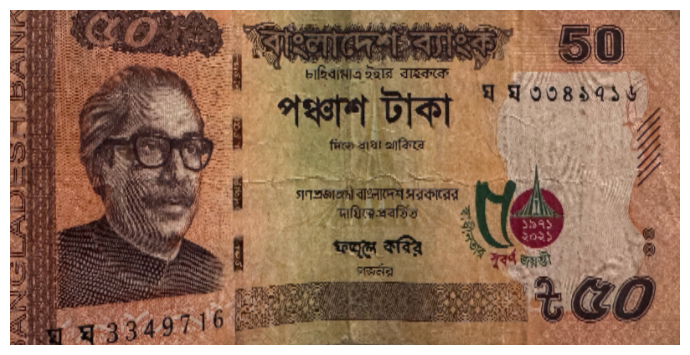

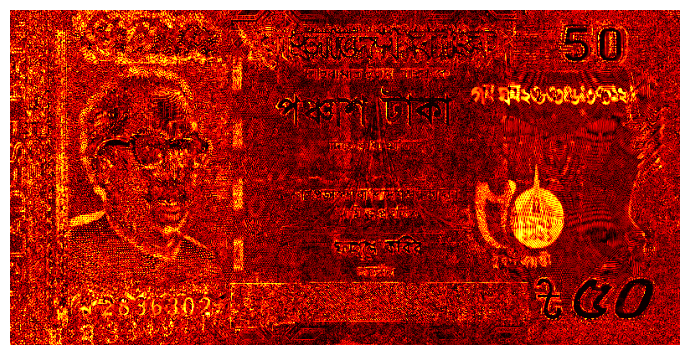


Damage Analysis Results:
Binary Damage: 0.0%
RGB Damage: 21.0%

Final CCDS Damage Summary:
Binary Damage (%): 0.0000
RGB Damage (%): 20.9730
Damaged Edges: 0
Damaged Corners: 0
Missing Features: 67
Total Features: 100
Damage Areas: 0
CCDS Score: 0.8905


In [25]:
if __name__ == "__main__":
    try:
        # analyze_currency('dataset/data_torn/20tornt_back.jpg', 'standard_notes/20_back_standard.jpg')
        analyze_currency2('data_torn/50_front.jpg', 'standard_notes/50_standard.jpg')
    except Exception as e:
        print(f"Error: {str(e)}")

Removing backgrounds...
Aligning images...
Processing analysis...
Detecting edge and corner damage...

Edge & Corner Damage Report:
Top Edge: OK (0.0% damaged)
Bottom Edge: OK (0.0% damaged)
Left Edge: OK (0.0% damaged)
Right Edge: OK (0.0% damaged)
Top Left Corner: OK (0.0% damaged)
Top Right Corner: OK (0.0% damaged)
Bottom Left Corner: OK (0.0% damaged)
Bottom Right Corner: OK (0.0% damaged)
Checking key features presence...

 Advanced feature detection & checking starting...
➡ Detected 7761 raw contours.
➡ 90 contours kept after filtering.
Grouped into 73 feature clusters.


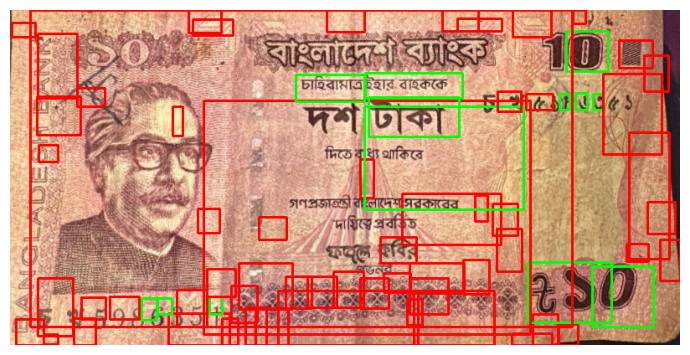


Top 5 damaged areas (if available):


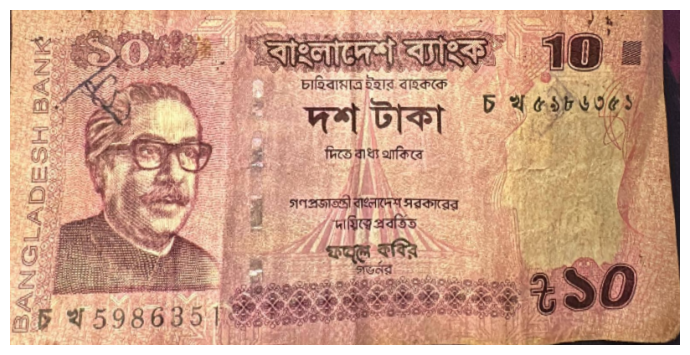

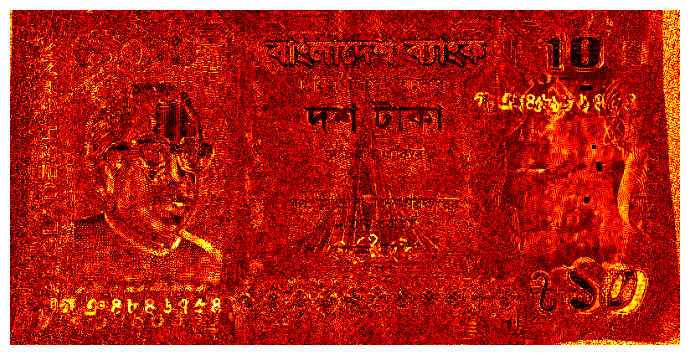


Damage Analysis Results:
Binary Damage: 0.0%
RGB Damage: 24.1%

Final CCDS Damage Summary:
Binary Damage (%): 0.0000
RGB Damage (%): 24.1346
Damaged Edges: 0
Damaged Corners: 0
Missing Features: 60
Total Features: 73
Damage Areas: 0
CCDS Score: 0.8735


In [26]:
if __name__ == "__main__":
    try:
        # analyze_currency('dataset/data_torn/20tornt_back.jpg', 'standard_notes/20_back_standard.jpg')
        analyze_currency2('data_torn/10_front.jpg', 'standard_notes/10_standard.jpg')
    except Exception as e:
        print(f"Error: {str(e)}")

Removing backgrounds...
Aligning images...
Processing analysis...
Detecting edge and corner damage...

Edge & Corner Damage Report:
Top Edge: OK (0.0% damaged)
Bottom Edge: OK (0.0% damaged)
Left Edge: OK (3.5% damaged)
Right Edge: OK (0.0% damaged)
Top Left Corner: OK (0.0% damaged)
Top Right Corner: OK (0.0% damaged)
Bottom Left Corner: OK (0.0% damaged)
Bottom Right Corner: OK (0.0% damaged)
Checking key features presence...

 Advanced feature detection & checking starting...
➡ Detected 2994 raw contours.
➡ 24 contours kept after filtering.
Grouped into 23 feature clusters.


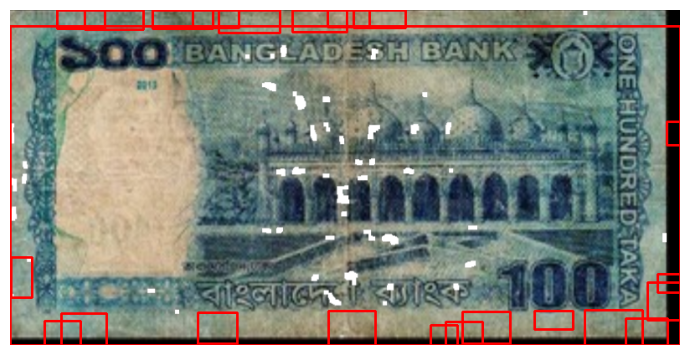


Top 5 damaged areas (if available):
Damage 1: Location - Middle Center, Area: 170 px
Damage 2: Location - Top Center, Area: 144 px
Damage 3: Location - Bottom Center, Area: 143 px
Damage 4: Location - Middle Center, Area: 125 px
Damage 5: Location - Bottom Center, Area: 107 px


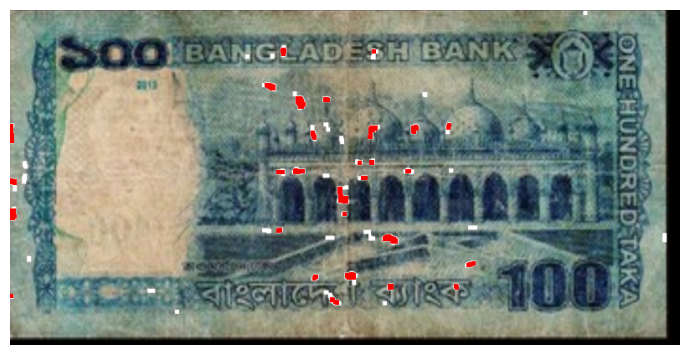

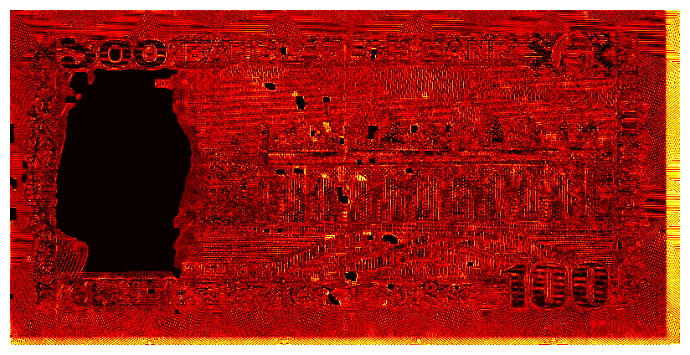


Damage Analysis Results:
Binary Damage: 0.7%
RGB Damage: 22.7%

Final CCDS Damage Summary:
Binary Damage (%): 0.6890
RGB Damage (%): 22.6983
Damaged Edges: 0
Damaged Corners: 0
Missing Features: 23
Total Features: 23
Damage Areas: 15
CCDS Score: 0.8373


In [27]:
if __name__ == "__main__":
    try:
        # analyze_currency('dataset/data_torn/20tornt_back.jpg', 'standard_notes/20_back_standard.jpg')
        analyze_currency2('data_torn/100_torn_back.jpg', 'standard_notes/100_back_standard.jpg')
    except Exception as e:
        print(f"Error: {str(e)}")